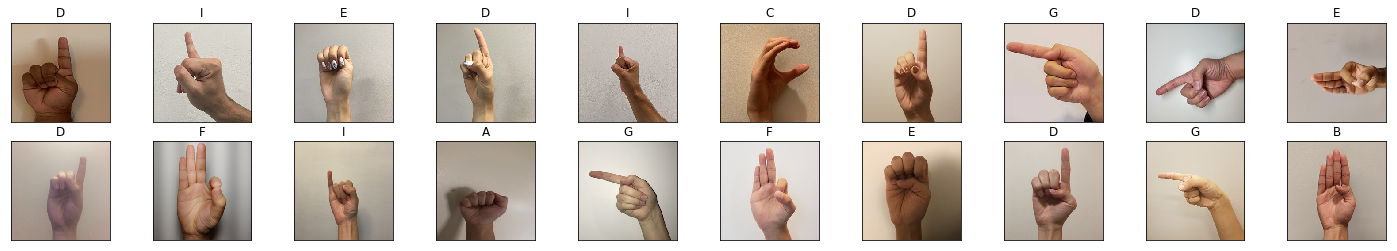

In [3]:
import torch
import numpy as np
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

# Images saved locally
masterPath = "C:\\Users\\Maxwell\\Documents\\Code\\Python\\APS360\\src\\Labs\\Lab3\\Images\\"

#Transform Settings
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

#Splits Data Sets
trainData = torchvision.datasets.ImageFolder(masterPath+"Train", transform=transform)
valData = torchvision.datasets.ImageFolder(masterPath+"Val", transform=transform)
testData = torchvision.datasets.ImageFolder(masterPath+"Test", transform=transform)

"""
Data was split so that ~60% of it is training, ~20% is validation, and ~%20 is testData
Sample code is shown below to indicate how I managed to automatically organize this data
"""

#Prepare Dataloader
trainSize = len(trainData)
batchSize = 32
numWorkers = 1

trainLoader = torch.utils.data.DataLoader(trainData, batch_size=batchSize, num_workers=numWorkers, shuffle=True)
valLoader = torch.utils.data.DataLoader(valData, batch_size=batchSize, num_workers=numWorkers, shuffle=True)
testLoader = torch.utils.data.DataLoader(testData, batch_size=batchSize, num_workers=numWorkers, shuffle=True)

#Verification
dataIter = iter(dataLoader)
images, labels = dataIter.next()
images = images.numpy()

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

#Visualize
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(letters[labels[idx]])




In [ ]:
"""
Sample code of how I organized my images in training, validation, and testing data sets


import os
import math
import shutil

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

path = "C:\\Users\\Maxwell\\Documents\\Code\\Python\\APS360\\src\\Labs\\Lab3\\Images"

for letter in letters:


    trainPath = path+"\\Train\\"+letter
    testPath = path+"\\Test\\"+letter
    valPath = path+"\\Val\\"+letter

    os.mkdir(trainPath)
    os.mkdir(valPath)
    os.mkdir(testPath)

    imgsPath = path+"\\Raw\\"+letter
    imgs = os.listdir(imgsPath)

    dirSize = len(imgs)
    trainSize = math.floor(dirSize*.6)
    valSize = math.floor(dirSize*0.2)
    testSize = math.ceil(dirSize*0.2)
    
    for i in range(dirSize):

        imgPath = imgsPath+"\\"+imgs[i]
        
        if i in range(trainSize):

            shutil.copy(imgPath, trainPath+"\\"+imgs[i])

        elif i in range(trainSize,trainSize+testSize):

            shutil.copy(imgPath, testPath+"\\"+imgs[i])

        elif i in range(trainSize+testSize,trainSize+testSize+valSize):

            shutil.copy(imgPath, valPath+"\\"+imgs[i])

"""

In [11]:
# Helper Functions

from typing import Callable, Tuple, List


def getModelName(name: str, batchSize: int, learningRate: float, epoch: int) -> str:
    
    """
    Generates the name of the model using the given hyperparamters values
    
    Parameters
    ---------
        name: str
            name of the model
        batchSize: int
            size of the training batch
        learningRate: float
            rate at which the model learns
        epoch:
            the specific training epoch that is exepected
    
    Returns
    =======
        str:
            the name of the model
    """
    
    
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batchSize, learningRate, epoch)
    
    return path


def normalizeLabels(labels: torch.Tensor()) -> torch.Tensor():
    
    """
    Normalize a tensor to 0 or 1
    
    Parameters
    ----------
    labels: torch.Tensor()
        1D tensor with two scalar values
    
    Returns
    =======
    torch.Tensor()
        tensor normalized to 0 or 1
    
    """
    
    maxVal = torch.max(labels)
    minval = torch.min(labels)
    normLabels = (labels-minVal)/(maxVal/minval)
    
    return normLabels


def evaluate(net: torch.nn, loader: torch.utils.data.DataLoader, criterion: Callable) -> Tuple[float]:
    
    """
    Evaluates the network with the validation data set
    
    Paramters
    ---------
    net: torch.nn
        PyTorch neural net
    loader: torch.utils.data.DataLoader
        PyTorch data loader for validation data set
    criterion:
        callable loss function
        
    Returns
    =======
    tuple(float):
        tuple of the average classifcation error and loss function over the validation data set
    
    """
    totalLoss = 0.0
    totalErr = 0.0
    totalEpoch = 0
    
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalizeLabel(labels)
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs>0.0).squeeze().long() != labels
        
        totalErr += int(corr.sum())
        totalLoss += loss.item()
        totalEpoch += len(labels)
    
    err = float(totalErr)/totalEpoch
    loss = float(totalLoss)/(i+1)
    
    return err, loss


def getRelevantIndices(dataset: torchvision.datasets.ImageFolder, classes: List[str], targetClasses: List(str)) -> List[int]:
    
    """
    Returns indices of datapoints from a datset that are part of the target classes
    
    Parameters
    ----------
    dataset: torchvision.datasets.ImageFolder
        PyTorch Dataset
    classes: List(str)
        name of each class
    targetClasses: List[str]
        desired classes
        
    Returns
    =======
    List[int]
        list of indices corresponding to desired classes
    
    """
    
    indices = []
    
    for i in range(len(dataset)):
        labelIndex = dataset[i][1]
        labelClass = classes[labelIndex]
        if labelClass in targetClasses:
            indices.append(i)
            
    return indices


def getDataLoader(targetClasses: List[str], batchSize: int) -> Tuple[torch.util.data.DataLoader]:
    
    """
    Generates the required data loaders from training, validation, and testing data sets 
    based on the desired target classes
    
    Parameters
    ----------
    targetClasses: List[str]
        list of desired classes
    batchSize: int
        size of the training batch
        
    Returns
    =======
    Tuple[torch.util.data.DataLoader]
        dataloaders for training, validation, and testing data sets
    """
    
    relevantTrainIndices = getRelevantIndices(trainData, letters, targetClasses)
    np.random.seed(1000)
    np.random.shuffle(relevantTrainIndices)
    trainSampler = SubsetRandomSampler(relevantTrainIndices)
    trainLoader = torch.utils.data.DataLoader(trainData, sampler=trainSampler, batch_size=batchSize, num_workers=1)
    
    relevantValIndices = getRelevantIndices(valData, letters, targetClasses)
    np.random.shuffle(relevantValIndices)
    valSampler = SubsetRandomSampler(relevantValIndices)
    valLoader = torch.utils.data.DataLoader(valData, sampler=valSampler, batch_size=batchSize, num_workers=1)
    
    relevantTestIndices = getRelevantIndices(testData, letters, targetClasses)
    testSampler = SubsetRandomSampler(relevantTestIndices)
    testLoader = torch.utils.data.DataLoader(testData, sampler=testSampler, batch_size=batchSize, num_workers=1)
    
    return trainLoader, valLoader, testLoader

TypeError: 'type' object is not iterable